In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation

%matplotlib inline

In [5]:
import numpy as np
from collections import Counter

from scipy.spatial import distance
from itertools import product

def steps_within_radius(radius=4, metric='euclidean'):
    """Return a list of all steps that stay within the given radius."""
    steps_within = [np.array(xy) for xy in product(range(-radius, radius), range(-radius, radius))
            if distance.pdist([(0,0), xy], metric=metric)[0]<=radius and xy!=(0,0)]
    return steps_within


class Team():
    
    def __init__(self, name, players, color):
        self.name = name
        self.players = players
        self.color = color
        
        # Let the players know where they belong
        for player in self.players:
            player.color = color
            player.team = self.name
        
    def __iter__(self):
        return iter(self.players)
    
    def __len__(self):
        return len(self.players)

# STATES:
# -1: out of boundaries
# 0-9: environment
# 10-: players (numbered)

class Environment():
    
    rewards = {
        'kill': 10,
        'death': -8,
        'base': 0,
    }
    
    colors = {  # color for rendering
        -1: (0,0,0),  # out of bounds
        0: (1,1,1),  # empty
        1: (0.5,0.5,0.5),  # obstacle
    }

    def __init__(self, teams, size=(100,100), obstacle_prob=.1):
        self.size = size  # size of the map
        self.states = [self._create_field(obstacle_prob)]
        
        # Adding both teams
        self.teams = teams
        self.num_players = sum([len(t) for t in self.teams])
        
        # Put the players on the map
        self.players = []  # Storing players in other list for convenience
        for team_ix,team in enumerate(self.teams):
            for player in team:
                self._add_player(player, team_ix=team_ix)
                
    def _create_field(self, obstacle_prob=.1):
        """Create a new map for simulation."""
        field = np.zeros(self.size)
        
        # Add obstacles
        field += 1.*(np.random.random_sample(self.size)<=obstacle_prob)
        
        return field
                
    def _new_state(self):
        self.states.append(np.copy(self._current_state()))
                
    def _current_state(self):
        return self.states[-1]
        
    def render(self, pix_per_field=3, state=None):
        assert pix_per_field%2==1,"Pixels per field should be odd, otherwise there might be issues in rendering!"
        
        if state is None:
            state = self._current_state()
        
        ppf = pix_per_field  # shorthand
        self.rendering = np.ones((*np.array(self.size)*pix_per_field, 3))
        #TODO make this more efficient somehow (some array processing way; only change if state is non0)
        for ix in range(self.size[0]):
            for jx in range(self.size[1]):
                self.rendering[max(0, ix*ppf-ppf//2):min(self.size[0]*ppf-1, ix*ppf+ppf//2+1),
                               max(0, jx*ppf-ppf//2):min(self.size[1]*ppf-1, jx*ppf+ppf+1)] = self.colors[state[ix,jx]]
                
        #FIXME seems to be some bug with rendering when player is at the border (might not show)
        
        return self.rendering
        
    def show(self, plotsize=(15,15), **kwargs):
        plt.figure(figsize=plotsize)
        plt.imshow(self.render(**kwargs))
        
    def _add_player(self, player, team_ix=0):
        state = self._current_state()
        
        found_position = False
        
        while not found_position:
            # We want the teams to spawn in separate regions
            x_pos = int(self.size[0]*(2*team_ix+np.random.rand())/(2*len(self.teams)-1))
            position = (x_pos, int(np.random.rand()*self.size[1]))
            if state[position] == 0:  # I.e. position is empty
                found_position = True
        
        if player.id_ is None:
            player_id = 10+len(self.players)
            player.id_ = player_id
            
        state[position] = player.id_
        
        self.colors[player.id_] = player.color
        self.players.append(player)
        player.env = self
        player.status = 'alive'
        
    def _player_by_id(self, id_):
        assert id_>=10,"Invalid player ID given!"
        return self.players[int(id_-10)]
    
    def _same_team(self, player_1, player_2=None, team=None):
        if player_2 is not None:
            if player_1.team==player_2.team:
                return True
        elif team is not None:
            if player_1.team==team.name:
                return True
        return False
        
    def tick(self):
        self._new_state()
        
        # Player movement
        for player in self.players:  #TODO randomize order every turn
            if player.status=='dead':
                continue
                
            env_info = player.vision_env()

            player.act(env_info)
        
        # Auto-attack
        attacked_player_ids = []
        attacked_by_player = {}
        for player in self.players:
            if player.status=='dead':
                continue
            
            attack_env = player.attack_env()
            
            # This player auto-attacks all players of other teams within this radius
            attacked_by_player[player.id_] = [s for s in attack_env
                                   if s>=10 and not self._same_team(player, self._player_by_id(s))]
            attacked_player_ids.extend(attacked_by_player[player.id_])
                    
        # Kill players if they are attacked at least twice in this round
        killed_players = [id_ for id_,count in Counter(attacked_player_ids).most_common() if count>=2]
        for id_ in killed_players:
            pos = self.get_player_position(id_)
            self._current_state()[pos[0], pos[1]] = 0
            self._player_by_id(id_).die()
            print("Player %d (Team %s) killed in round %d!"%(id_, self._player_by_id(id_).team, len(self.states)))
        
        # Give rewards to the players and info about the next state, have them learn
        for player in self.players:
            
            # Compute next state and reward
            state = player.last_vision_env
            if state is None:  # Player most likely was dead already at beginning of round
                continue
            action = player.last_action
            next_state = player.vision_env()
            reward = self.rewards['base']
            if player.id_ in killed_players:
                reward += self.rewards['death']
            # Figure out kills by the player
            if player.id_ in attacked_by_player:
                for oid in attacked_by_player[player.id_]:
                    if oid in killed_players:
                        reward += self.rewards['kill']
            
            # Add info to memory and update the player
            player.add_memory(state, action, next_state, reward)
            player.learn()
                    
        # Determine if game is over
        alive_by_team = {team.name: len([player for player in self.players
                                    if player.status!='dead' and self._same_team(player, team=team)])
                         for team in self.teams}
        alive_teams = [team for team in alive_by_team if alive_by_team[team]>1]
        if len(alive_teams)<2:
            print("Game over.")
            if len(alive_teams)==1:
                print("Winner: Team", alive_teams[0])
            else:
                print("Draw: No survivors.")
            return False
        return True
        
    def _valid_coordinate(self, coord):
        if coord[0]>=0 and coord[0]<self.size[0] and coord[1]>=0 and coord[1]<self.size[1]:
            return True
        else:
            return False
        
    def get_env(self, player, radius):
        player_position = self.get_player_position(player.id_)
        
        if player_position is None:  # i.e. player is not on the map
            return None
        
        state = self._current_state()

        # Find the part of the environment that is within the players field of vision
        steps = steps_within_radius(radius=radius)
        env = [state[player_position[0]+step[0], player_position[1]+step[1]]
                     if self._valid_coordinate(player_position+step) else -1
               for step in steps]
        
        return env
    
    def get_player_position(self, player_id):
        state = self._current_state()
        cur_x, cur_y = np.where(state==player_id)
        
        if len(cur_x):
            player_position = np.array((cur_x[0], cur_y[0]))
            return player_position
        else:  # Player is not on the map
            return None
    
    def request_move(self, player_id, direction):
        state = self._current_state()
        
        current_player_position = self.get_player_position(player_id)
        requested_position = current_player_position+np.array(direction)
        
        # If any coordinate is outside the field the move is invalid
        if min(requested_position)<0 or requested_position[0]>=self.size[0] or requested_position[1]>=self.size[1]:
            return False
        
        # If the field is not empty the move is invalid
        if state[requested_position[0], requested_position[1]]!=0:
            return False
        
        # Move is valid, so move the player
        state[requested_position[0], requested_position[1]] = player_id
        state[current_player_position[0], current_player_position[1]] = 0
        return True


    
# ACTIONS
# 0: stay
# 1: move up
# 2: move right
# 3: move down
# 4: move left
# 5-8: attack up/right/down/left

class Player():
    
    vision_radius = 6
    attack_radius = 3
    
    actions = {
        0: ('move', (0,0)),  # stay
        1: ('move', (1,0)),  # move up
        2: ('move', (0,1)),  # move right
        3: ('move', (-1,0)),  # move down
        4: ('move', (0,-1)),  # move left
        #TODO also implement attacks
    }
    
    # Attributes to be set by environment or Team
    env = None
    color = None
    team = None
    id_ = None
    status = None
    
    def __init__(self):
        pass

    def die(self):
        self.status = 'dead'
        
    def vision_env(self):
        ve = self.env.get_env(player=self, radius=self.vision_radius)
        self.last_vision_env = ve
        return ve  # Remember for learning
    
    def attack_env(self):
        ae = self.env.get_env(player=self, radius=self.attack_radius)
        self.last_attack_env = ae
        return ae
        
    def do(self, action_id):
        assert self.status!='dead'
        
        action_params = self.actions[action_id][1]
        action = self.actions[action_id][0]
        if action=='move':
            self.move(action_params)
        else:
            raise Exception('Invalid action selected!')
        
    def move(self, direction=(1,0)):
        self.env.request_move(player_id=self.id_, direction=direction)
        
    def add_memory(self, *args):
        pass
    
    def learn(self):
        pass
        

class RandomPlayer(Player):
    
    def act(self, env):  #TODO also consider communication, or have agent see others actions
        action_id = np.random.choice(list(self.actions.keys()))
        self.last_action = action_id
        self.do(action_id)

In [6]:
def create_teams(num_players=4, player_class=RandomPlayer):
    teams = []
    teams.append(Team(name="Red", color=(1,0,0), players=[player_class() for _ in range(num_players)]))
    teams.append(Team(name="Blue", color=(0,0,1), players=[player_class() for _ in range(num_players)]))
    return teams

In [7]:
env = Environment(size=(10,10), teams=create_teams())

for i in range(5):
    if i%10==0:
        print("Round %d"%i)
    if not env.tick():
        break
print(i)
    
len(env.states)

Round 0
4


6

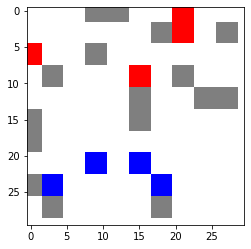

In [8]:
plt.imshow(env.render(state=env.states[0]))

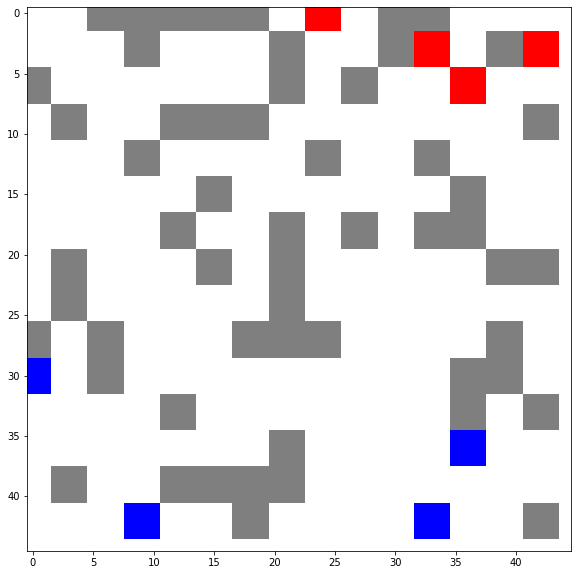

In [17]:
# Render from precomputed
fig = plt.figure(figsize=(10,10))

def init():
    ln = plt.imshow(env.render(state=env.states[0]))
    return ln

def update(frame):   
    ln = plt.imshow(env.render(state=frame))
    return ln

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5)
ani = FuncAnimation(fig, update, frames=env.states[1:],
                    init_func=init, blit=False)
ani.save('test_precomputed.mp4', writer=writer)

## Training

In [9]:
import math
import random
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [14]:
class DQN(nn.Module):

    #def __init__(self, h, w, outputs):
    def __init__(self, one_hot_size, in_dim, outputs, hidden_dim=10):
        super(DQN, self).__init__()
        
        self.n = one_hot_size
        self.in_dim = in_dim
        
        self.fc1 = nn.Linear(self.n*self.in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = nn.functional.one_hot(x.to(torch.int64), self.n)
        # Flatten
        x = x.reshape((-1, self.n*self.in_dim))

        x = F.relu(self.fc1(x.to(torch.float)))
        #x = F.relu(self.bn3(self.conv3(x)))
        #return self.head(x.view(x.size(0), -1))
        return self.fc2(x)
    

class TrainablePlayer(Player):

    MEMORY_SIZE = 2000
    BATCH_SIZE = 16
    GAMMA = 0.999
    EPS_START = 0.9
    EPS_END = 0.05
    EPS_DECAY = 500 #200
    TARGET_UPDATE = 100 # Note that this corresponds to number of steps, not games
    
    policy_net = None
    target_net = None
    
    def init_networks(self):        
        # Figure out dimensions of input and ouput to initialize networks
        self.n_actions = len(self.actions)
        self.env_dim = len(self.vision_env())
        
        # Also inform the player about team membership
        self.team_of_player_id = {}
        for i,team in enumerate(self.env.teams):
            for player in team:
                self.team_of_player_id[player.id_] = i #team.name
        
        self.one_hot_size = 1 + 10 + len(self.team_of_player_id) #self.env.num_players
        
        # Set up the networks
        self.policy_net = DQN(self.one_hot_size, self.env_dim, self.n_actions).to(device)
        #DQN(screen_height, screen_width, n_actions).to(device)
        self.target_net = DQN(self.one_hot_size, self.env_dim, self.n_actions).to(device)
        #DQN(screen_height, screen_width, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = ReplayMemory(self.MEMORY_SIZE)
        self.steps_done = 0

    def act(self, env):
        if self.policy_net is None:
            self.init_networks()
        
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) \
                        * math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                
                # Modify values a bit to make compatible with pytorch processing
                state = self._env_to_state(env)
                action_tensor = self.policy_net(state.reshape(1, -1)).max(1)[1].view(1, 1)
        else:
            action_tensor = torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)
            
        self.last_action = action_tensor
        
        action_id = int(action_tensor.numpy())
        self.do(action_id)

    def add_memory(self, state, action, next_state, reward):
        self.memory.push(self._env_to_state(state), action, self._env_to_state(next_state), torch.tensor([reward]))
        
    def _env_to_state(self, env):
        if env is not None:
            # Map players of the same team on same value
            s = [self.team_of_player_id[val] if val>=10 else val for val in env]
            
            return torch.tensor(np.array(s)+1, device=device, dtype=torch.int)
        else:
            return None
    
    def learn(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        # Update the target network, copying all weights and biases in DQN
        if self.steps_done % self.TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            

# We have one shared net per team
shared_policy_net = {}
shared_target_net = {}

class SharedTrainablePlayer(TrainablePlayer):
    
    def init_networks(self):        
        # Figure out dimensions of input and ouput to initialize networks
        self.n_actions = len(self.actions)
        self.env_dim = len(self.vision_env())

        # Also inform the player about team membership
        self.team_of_player_id = {}
        for i,team in enumerate(self.env.teams):
            for player in team:
                self.team_of_player_id[player.id_] = i #team.name
        
        self.one_hot_size = 1 + 10 + len(self.team_of_player_id) #self.env.num_players
        
        global shared_policy_net
        if self.team not in shared_policy_net:
            shared_policy_net[self.team] = DQN(self.one_hot_size, self.env_dim, self.n_actions).to(device)
        self.policy_net = shared_policy_net[self.team]
        #DQN(screen_height, screen_width, n_actions).to(device)
        global shared_target_net
        if self.team not in shared_target_net:
            shared_target_net[self.team] = DQN(self.one_hot_size, self.env_dim, self.n_actions).to(device)
        self.target_net = shared_target_net[self.team]
        #DQN(screen_height, screen_width, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = ReplayMemory(self.MEMORY_SIZE)
        self.steps_done = 0


In [15]:
num_players = 4

teams = []
#teams.append(Team(name="Trainable", color=(1,0,0), players=[TrainablePlayer() for _ in range(num_players)]))
teams.append(Team(name="Red", color=(1,0,0), players=[SharedTrainablePlayer() for _ in range(num_players)]))
#teams.append(Team(name="Random", color=(0,0,1), players=[RandomPlayer() for _ in range(num_players)]))
teams.append(Team(name="Blue", color=(0,0,1), players=[SharedTrainablePlayer() for _ in range(num_players)]))

In [16]:
num_games = 30

for i_game in range(num_games):
    print("Starting game nr %d ..."%(i_game+1))
    
    # Initialize the environment and state
    env = Environment(size=(15,15), teams=teams)

    #last_screen = get_screen()
    #current_screen = get_screen()
    #state = current_screen - last_screen
    
    for t in count():
        if not env.tick() or t>100:
            break

print('Complete.')

Starting game nr 1 ...
Starting game nr 2 ...
Starting game nr 3 ...
Player 11 (Team Red) killed in round 54!
Player 12 (Team Red) killed in round 78!
Player 16 (Team Blue) killed in round 96!
Starting game nr 4 ...
Player 16 (Team Blue) killed in round 69!
Player 14 (Team Blue) killed in round 97!
Starting game nr 5 ...
Player 15 (Team Blue) killed in round 63!
Player 11 (Team Red) killed in round 63!
Player 17 (Team Blue) killed in round 75!
Starting game nr 6 ...
Player 12 (Team Red) killed in round 29!
Player 13 (Team Red) killed in round 46!
Player 11 (Team Red) killed in round 55!
Game over.
Winner: Team Blue
Starting game nr 7 ...
Player 16 (Team Blue) killed in round 11!
Player 14 (Team Blue) killed in round 38!
Player 15 (Team Blue) killed in round 59!
Game over.
Winner: Team Red
Starting game nr 8 ...
Starting game nr 9 ...
Starting game nr 10 ...
Starting game nr 11 ...
Starting game nr 12 ...
Starting game nr 13 ...
Player 17 (Team Blue) killed in round 25!
Player 14 (Team 

Few things we want:

- Each tick, each player can
    - Move or attack (only up/right/down/left)
    - Communicate up to c characters (within some l1 radius, everyone can hear that)
- If two or more players from one team simultaneously attack another player, that player dies
- Rewards are given for each kill and if the team wins
- Each player should see only to some l1 radius and hear what is said in another l1 radius


TODO: 

- obstacles:
    - make sure it doesn't mappen that the whole spawning area is covered (very unlikely but can happen)
    - make it impossible to see or attack through obstacles
- improve learning
    - synchronization (might need to read on how distributed learning is implemented)
    - might need to change learning a bit to favor episodes with non-0 reward
    - speed up so training can be longer (might be solved by proper synchronization already)
- speed up rendering (perhaps do as image sequence instead of vid, that should be faster)
- add communication ability
- give memory to players
- enable better attacking (and show such actions in rendering by lighter colors)
- there could be movable objects or other modifiers (e.g. for larger communication radius)
- have players face a certain direction
- can make the players respawn and gain experience or other status
    - attack could first only go one field but distance be increased
    - players loosing energy over time and need to recharge somewhere
- vary number of players, perhaps have them find a good trade-off between complexity of model and number of players
- try different learning approaches including evolution and compare
